In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    # rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [7]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                    labels=tf.zeros_like(gQs2))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    # ##################################################### repeatable!
    # next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
    #                                reuse=True)
    # next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
    #                             reuse=True)
    # gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits, 
    #                      action_size=action_size, reuse=True)
    # dones2 = tf.concat(axis=0, values=[dones[1:], tf.ones(shape=[1])])
    # gQs3 = tf.reshape(gQs3, shape=[-1]) * (1-dones2)
    # dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                 labels=tf.zeros_like(gQs3))) # 0-1
    # aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                  labels=tf.ones_like(gQs3))) # 0-1
    return actions_logits, aloss, dloss, aloss2

In [8]:
def model_opt(a_loss, d_loss, a_loss2, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    #g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        d_loss=self.d_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [10]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [11]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [13]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
# gamma = 0.99                   # future reward discount

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, 
              d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [15]:
state = env.reset()
total_reward = 0
num_step = 0
rate = -1
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset
        rate = -1 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        #aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        rate = -1 # unrated

        # Sampling
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            if done is True:
                break
        
        # Rating
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
        # Training
        batch = memory.buffer
        for idx in range(memory_size// batch_size):
        # while True:
        #     idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            #rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates == np.max(rates)]
            actions = actions[rates == np.max(rates)]
            next_states = next_states[rates == np.max(rates)]
            #rewards = rewards[rates == np.max(rates)]
            dones = dones[rates == np.max(rates)]
            rates = rates[rates == np.max(rates)]
            #if np.count_nonzero(dones)==1 and len(dones) > 1 and np.max(rates) > 0:
            if len(dones) > 1:
                aloss, _ = sess.run([model.a_loss, model.a_opt],
                                    feed_dict = {model.states: states, 
                                                model.actions: actions,
                                                model.next_states: next_states,
                                                #model.rewards: rewards,
                                                model.dones: dones,
                                                model.rates: rates})
                dloss, _ = sess.run([model.d_loss, model.d_opt],
                                      feed_dict = {model.states: states, 
                                                   model.actions: actions,
                                                   model.next_states: next_states,
                                                   #model.rewards: rewards,
                                                   model.dones: dones,
                                                   model.rates: rates})
                aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                     feed_dict = {model.states: states, 
                                                  model.actions: actions,
                                                  model.next_states: next_states,
                                                  #model.rewards: rewards,
                                                  model.dones: dones,
                                                  model.rates: rates})

        # Printing
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss)),
              'dloss:{:.4f}'.format(np.mean(dloss)),
              'aloss2:{:.4f}'.format(np.mean(aloss2)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0000 rate:0.0280 aloss:1.3915 dloss:2.0121 aloss2:1.4104 exploreP:0.9986
Episode:1 meanR:20.5000 R:27.0000 rate:0.0540 aloss:1.3898 dloss:1.9083 aloss2:1.4846 exploreP:0.9959
Episode:2 meanR:20.3333 R:20.0000 rate:0.0400 aloss:1.3881 dloss:1.8020 aloss2:1.5705 exploreP:0.9940
Episode:3 meanR:23.5000 R:33.0000 rate:0.0660 aloss:1.3870 dloss:1.6991 aloss2:1.6634 exploreP:0.9907
Episode:4 meanR:22.8000 R:20.0000 rate:0.0400 aloss:1.3869 dloss:1.6044 aloss2:1.7579 exploreP:0.9888
Episode:5 meanR:22.1667 R:19.0000 rate:0.0380 aloss:1.3870 dloss:1.5119 aloss2:1.8619 exploreP:0.9869
Episode:6 meanR:21.0000 R:14.0000 rate:0.0280 aloss:1.3875 dloss:1.4237 aloss2:1.9746 exploreP:0.9856
Episode:7 meanR:19.7500 R:11.0000 rate:0.0220 aloss:1.3878 dloss:1.3400 aloss2:2.0962 exploreP:0.9845
Episode:8 meanR:20.2222 R:24.0000 rate:0.0480 aloss:1.3884 dloss:1.2619 aloss2:2.2251 exploreP:0.9821
Episode:9 meanR:20.7000 R:25.0000 rate:0.0500 aloss:1.3890 dloss:1.1890 aloss2:2.3

Episode:80 meanR:27.3951 R:45.0000 rate:0.0900 aloss:1.4778 dloss:0.5612 aloss2:6.3295 exploreP:0.8030
Episode:81 meanR:27.8659 R:66.0000 rate:0.1320 aloss:1.4774 dloss:0.5609 aloss2:6.3057 exploreP:0.7978
Episode:82 meanR:27.6988 R:14.0000 rate:0.0280 aloss:1.4761 dloss:0.5608 aloss2:6.3194 exploreP:0.7967
Episode:83 meanR:27.5357 R:14.0000 rate:0.0280 aloss:1.4744 dloss:0.5606 aloss2:6.3332 exploreP:0.7956
Episode:84 meanR:27.3765 R:14.0000 rate:0.0280 aloss:1.4727 dloss:0.5603 aloss2:6.3424 exploreP:0.7945
Episode:85 meanR:27.1628 R:9.0000 rate:0.0180 aloss:1.4719 dloss:0.5600 aloss2:6.3415 exploreP:0.7938
Episode:86 meanR:27.1724 R:28.0000 rate:0.0560 aloss:1.4744 dloss:0.5598 aloss2:6.3423 exploreP:0.7916
Episode:87 meanR:27.0568 R:17.0000 rate:0.0340 aloss:1.4762 dloss:0.5596 aloss2:6.3381 exploreP:0.7902
Episode:88 meanR:26.8989 R:13.0000 rate:0.0260 aloss:1.4778 dloss:0.5594 aloss2:6.3386 exploreP:0.7892
Episode:89 meanR:27.0000 R:36.0000 rate:0.0720 aloss:1.4798 dloss:0.5594 a

Episode:159 meanR:39.9100 R:54.0000 rate:0.1080 aloss:1.3336 dloss:1.3408 aloss2:6.2954 exploreP:0.5881
Episode:160 meanR:40.2200 R:75.0000 rate:0.1500 aloss:1.3653 dloss:1.3268 aloss2:6.2991 exploreP:0.5838
Episode:161 meanR:40.3700 R:38.0000 rate:0.0760 aloss:1.4384 dloss:1.3369 aloss2:6.1225 exploreP:0.5816
Episode:162 meanR:40.4900 R:66.0000 rate:0.1320 aloss:1.3416 dloss:0.8962 aloss2:6.1927 exploreP:0.5778
Episode:163 meanR:41.2100 R:106.0000 rate:0.2120 aloss:1.3411 dloss:0.8971 aloss2:6.2024 exploreP:0.5718
Episode:164 meanR:42.7300 R:192.0000 rate:0.3840 aloss:1.2976 dloss:1.2840 aloss2:6.2863 exploreP:0.5611
Episode:165 meanR:44.3200 R:227.0000 rate:0.4540 aloss:1.3081 dloss:1.4687 aloss2:6.3024 exploreP:0.5488
Episode:166 meanR:46.3500 R:238.0000 rate:0.4760 aloss:1.3103 dloss:1.5206 aloss2:6.2582 exploreP:0.5361
Episode:167 meanR:46.7600 R:72.0000 rate:0.1440 aloss:1.3102 dloss:1.5202 aloss2:6.2385 exploreP:0.5323
Episode:168 meanR:47.6000 R:108.0000 rate:0.2160 aloss:1.309

Episode:237 meanR:187.8500 R:280.0000 rate:0.5600 aloss:1.2379 dloss:1.5890 aloss2:5.0985 exploreP:0.1105
Episode:238 meanR:190.2700 R:260.0000 rate:0.5200 aloss:1.2364 dloss:1.5853 aloss2:5.0596 exploreP:0.1079
Episode:239 meanR:191.9400 R:272.0000 rate:0.5440 aloss:1.2662 dloss:1.5528 aloss2:4.8268 exploreP:0.1053
Episode:240 meanR:194.0800 R:228.0000 rate:0.4560 aloss:1.2556 dloss:1.5565 aloss2:4.9371 exploreP:0.1031
Episode:241 meanR:196.3200 R:278.0000 rate:0.5560 aloss:1.2423 dloss:1.5565 aloss2:5.0272 exploreP:0.1006
Episode:242 meanR:199.2000 R:317.0000 rate:0.6340 aloss:1.2337 dloss:1.7442 aloss2:5.0635 exploreP:0.0977
Episode:243 meanR:199.6500 R:250.0000 rate:0.5000 aloss:1.2314 dloss:1.7427 aloss2:5.0534 exploreP:0.0956
Episode:244 meanR:202.2100 R:379.0000 rate:0.7580 aloss:1.2193 dloss:2.0433 aloss2:5.1023 exploreP:0.0924
Episode:245 meanR:205.4600 R:350.0000 rate:0.7000 aloss:1.2192 dloss:2.0376 aloss2:5.0800 exploreP:0.0896
Episode:246 meanR:208.7100 R:342.0000 rate:0.6

Episode:315 meanR:314.3500 R:431.0000 rate:0.8620 aloss:1.1479 dloss:2.2088 aloss2:3.9568 exploreP:0.0180
Episode:316 meanR:314.8900 R:354.0000 rate:0.7080 aloss:1.1455 dloss:2.1556 aloss2:3.7551 exploreP:0.0177
Episode:317 meanR:314.5200 R:213.0000 rate:0.4260 aloss:1.2347 dloss:2.3218 aloss2:2.9610 exploreP:0.0175
Episode:318 meanR:317.2100 R:500.0000 rate:1.0000 aloss:1.1503 dloss:2.2637 aloss2:4.1444 exploreP:0.0171
Episode:319 meanR:318.9900 R:416.0000 rate:0.8320 aloss:1.1476 dloss:2.2582 aloss2:4.1259 exploreP:0.0169
Episode:320 meanR:319.2400 R:289.0000 rate:0.5780 aloss:1.1455 dloss:2.2669 aloss2:4.1357 exploreP:0.0167
Episode:321 meanR:318.8000 R:193.0000 rate:0.3860 aloss:1.1446 dloss:2.2894 aloss2:4.1587 exploreP:0.0165
Episode:322 meanR:319.0400 R:241.0000 rate:0.4820 aloss:1.1337 dloss:2.0267 aloss2:4.3676 exploreP:0.0164
Episode:323 meanR:317.0000 R:216.0000 rate:0.4320 aloss:1.1166 dloss:2.2222 aloss2:5.0950 exploreP:0.0162
Episode:324 meanR:319.1000 R:500.0000 rate:1.0

Episode:393 meanR:381.4300 R:500.0000 rate:1.0000 aloss:1.1289 dloss:1.9752 aloss2:3.0782 exploreP:0.0104
Episode:394 meanR:384.7800 R:500.0000 rate:1.0000 aloss:1.1080 dloss:1.9526 aloss2:2.9775 exploreP:0.0104
Episode:395 meanR:385.9200 R:368.0000 rate:0.7360 aloss:1.0977 dloss:1.9455 aloss2:2.9074 exploreP:0.0103
Episode:396 meanR:388.1900 R:500.0000 rate:1.0000 aloss:1.1026 dloss:1.9573 aloss2:2.9674 exploreP:0.0103
Episode:397 meanR:388.1900 R:500.0000 rate:1.0000 aloss:1.1162 dloss:1.9484 aloss2:2.9392 exploreP:0.0103
Episode:398 meanR:389.1200 R:356.0000 rate:0.7120 aloss:1.1105 dloss:1.9421 aloss2:2.9184 exploreP:0.0103
Episode:399 meanR:386.4600 R:234.0000 rate:0.4680 aloss:1.1082 dloss:1.9278 aloss2:2.8721 exploreP:0.0103
Episode:400 meanR:386.9800 R:500.0000 rate:1.0000 aloss:1.1203 dloss:1.9458 aloss2:2.9404 exploreP:0.0103
Episode:401 meanR:389.7900 R:500.0000 rate:1.0000 aloss:1.1223 dloss:1.9417 aloss2:2.9412 exploreP:0.0103
Episode:402 meanR:391.7100 R:500.0000 rate:1.0

Episode:471 meanR:460.3200 R:500.0000 rate:1.0000 aloss:1.1026 dloss:1.7938 aloss2:2.5142 exploreP:0.0100
Episode:472 meanR:462.2600 R:500.0000 rate:1.0000 aloss:1.1098 dloss:1.8027 aloss2:2.4788 exploreP:0.0100
Episode:473 meanR:461.7300 R:396.0000 rate:0.7920 aloss:1.1158 dloss:1.8130 aloss2:2.4498 exploreP:0.0100
Episode:474 meanR:461.7300 R:500.0000 rate:1.0000 aloss:1.1186 dloss:1.7944 aloss2:2.4741 exploreP:0.0100
Episode:475 meanR:461.7300 R:500.0000 rate:1.0000 aloss:1.1021 dloss:1.7918 aloss2:2.4829 exploreP:0.0100
Episode:476 meanR:461.7300 R:500.0000 rate:1.0000 aloss:1.0899 dloss:1.7974 aloss2:2.4599 exploreP:0.0100
Episode:477 meanR:460.7800 R:405.0000 rate:0.8100 aloss:1.0823 dloss:1.8048 aloss2:2.4407 exploreP:0.0100
Episode:478 meanR:462.5700 R:482.0000 rate:0.9640 aloss:1.0360 dloss:1.8066 aloss2:2.4321 exploreP:0.0100
Episode:479 meanR:463.1000 R:500.0000 rate:1.0000 aloss:1.1168 dloss:1.7866 aloss2:2.4741 exploreP:0.0100
Episode:480 meanR:463.1000 R:500.0000 rate:1.0

Episode:549 meanR:493.0000 R:500.0000 rate:1.0000 aloss:1.1246 dloss:1.7185 aloss2:2.4105 exploreP:0.0100
Episode:550 meanR:493.0000 R:500.0000 rate:1.0000 aloss:1.1203 dloss:1.7148 aloss2:2.4201 exploreP:0.0100
Episode:551 meanR:493.0000 R:500.0000 rate:1.0000 aloss:1.1161 dloss:1.7248 aloss2:2.3979 exploreP:0.0100
Episode:552 meanR:493.0000 R:500.0000 rate:1.0000 aloss:1.1196 dloss:1.7157 aloss2:2.4126 exploreP:0.0100
Episode:553 meanR:493.0000 R:500.0000 rate:1.0000 aloss:1.1214 dloss:1.7058 aloss2:2.4247 exploreP:0.0100
Episode:554 meanR:493.0000 R:500.0000 rate:1.0000 aloss:1.1222 dloss:1.7146 aloss2:2.4115 exploreP:0.0100
Episode:555 meanR:492.6500 R:464.0000 rate:0.9280 aloss:1.1214 dloss:1.7120 aloss2:2.4110 exploreP:0.0100
Episode:556 meanR:492.6500 R:500.0000 rate:1.0000 aloss:1.0933 dloss:1.7179 aloss2:2.3918 exploreP:0.0100
Episode:557 meanR:492.6500 R:500.0000 rate:1.0000 aloss:1.1088 dloss:1.7217 aloss2:2.3887 exploreP:0.0100
Episode:558 meanR:492.6500 R:500.0000 rate:1.0

Episode:627 meanR:450.3100 R:500.0000 rate:1.0000 aloss:1.1225 dloss:1.6663 aloss2:2.3981 exploreP:0.0100
Episode:628 meanR:450.3100 R:500.0000 rate:1.0000 aloss:1.1121 dloss:1.6404 aloss2:2.4380 exploreP:0.0100
Episode:629 meanR:450.3900 R:500.0000 rate:1.0000 aloss:1.1019 dloss:1.6315 aloss2:2.4523 exploreP:0.0100
Episode:630 meanR:450.3900 R:500.0000 rate:1.0000 aloss:1.1051 dloss:1.6449 aloss2:2.4252 exploreP:0.0100
Episode:631 meanR:450.3900 R:500.0000 rate:1.0000 aloss:1.1144 dloss:1.6478 aloss2:2.4244 exploreP:0.0100
Episode:632 meanR:450.3900 R:500.0000 rate:1.0000 aloss:1.1177 dloss:1.6511 aloss2:2.4246 exploreP:0.0100
Episode:633 meanR:446.8200 R:143.0000 rate:0.2860 aloss:1.1169 dloss:1.6466 aloss2:2.4308 exploreP:0.0100
Episode:634 meanR:447.2800 R:500.0000 rate:1.0000 aloss:1.1113 dloss:1.6403 aloss2:2.4349 exploreP:0.0100
Episode:635 meanR:447.2800 R:500.0000 rate:1.0000 aloss:1.1036 dloss:1.6254 aloss2:2.4553 exploreP:0.0100
Episode:636 meanR:447.2800 R:500.0000 rate:1.0

Episode:705 meanR:363.6800 R:357.0000 rate:0.7140 aloss:1.0768 dloss:1.4489 aloss2:2.8161 exploreP:0.0100
Episode:706 meanR:363.6800 R:500.0000 rate:1.0000 aloss:1.0735 dloss:1.4414 aloss2:2.8051 exploreP:0.0100
Episode:707 meanR:363.6800 R:500.0000 rate:1.0000 aloss:1.0823 dloss:1.4830 aloss2:2.7250 exploreP:0.0100
Episode:708 meanR:363.6800 R:500.0000 rate:1.0000 aloss:1.0987 dloss:1.5523 aloss2:2.5847 exploreP:0.0100
Episode:709 meanR:358.9600 R:28.0000 rate:0.0560 aloss:1.0992 dloss:1.5503 aloss2:2.5909 exploreP:0.0100
Episode:710 meanR:355.9400 R:198.0000 rate:0.3960 aloss:1.1002 dloss:1.5497 aloss2:2.5888 exploreP:0.0100
Episode:711 meanR:351.3800 R:44.0000 rate:0.0880 aloss:1.1001 dloss:1.5453 aloss2:2.5991 exploreP:0.0100
Episode:712 meanR:351.3800 R:10.0000 rate:0.0200 aloss:1.0999 dloss:1.5409 aloss2:2.6090 exploreP:0.0100
Episode:713 meanR:347.0500 R:67.0000 rate:0.1340 aloss:1.1004 dloss:1.5410 aloss2:2.6131 exploreP:0.0100
Episode:714 meanR:347.3000 R:84.0000 rate:0.1680 a

Episode:783 meanR:301.9600 R:500.0000 rate:1.0000 aloss:1.0826 dloss:1.4228 aloss2:2.9010 exploreP:0.0100
Episode:784 meanR:301.9600 R:10.0000 rate:0.0200 aloss:1.0828 dloss:1.4207 aloss2:2.9070 exploreP:0.0100
Episode:785 meanR:301.9600 R:10.0000 rate:0.0200 aloss:1.0826 dloss:1.4208 aloss2:2.9111 exploreP:0.0100
Episode:786 meanR:301.4400 R:448.0000 rate:0.8960 aloss:1.0710 dloss:1.3877 aloss2:2.8620 exploreP:0.0100
Episode:787 meanR:306.3400 R:500.0000 rate:1.0000 aloss:1.0883 dloss:1.4920 aloss2:2.8536 exploreP:0.0100
Episode:788 meanR:306.3400 R:10.0000 rate:0.0200 aloss:1.0884 dloss:1.4927 aloss2:2.8618 exploreP:0.0100
Episode:789 meanR:307.5800 R:500.0000 rate:1.0000 aloss:1.0918 dloss:1.4834 aloss2:2.8958 exploreP:0.0100
Episode:790 meanR:302.6800 R:10.0000 rate:0.0200 aloss:1.0920 dloss:1.4824 aloss2:2.9065 exploreP:0.0100
Episode:791 meanR:302.6800 R:500.0000 rate:1.0000 aloss:1.0964 dloss:1.4638 aloss2:2.9249 exploreP:0.0100
Episode:792 meanR:302.6800 R:500.0000 rate:1.0000 

Episode:861 meanR:289.0400 R:10.0000 rate:0.0200 aloss:1.0845 dloss:1.3549 aloss2:3.2729 exploreP:0.0100
Episode:862 meanR:293.6400 R:500.0000 rate:1.0000 aloss:1.0851 dloss:1.3541 aloss2:3.1808 exploreP:0.0100
Episode:863 meanR:295.0800 R:500.0000 rate:1.0000 aloss:1.0870 dloss:1.3273 aloss2:3.3023 exploreP:0.0100
Episode:864 meanR:291.7800 R:170.0000 rate:0.3400 aloss:1.0914 dloss:1.3274 aloss2:3.3076 exploreP:0.0100
Episode:865 meanR:286.8800 R:10.0000 rate:0.0200 aloss:1.0912 dloss:1.3264 aloss2:3.3117 exploreP:0.0100
Episode:866 meanR:285.9200 R:11.0000 rate:0.0220 aloss:1.0913 dloss:1.3248 aloss2:3.3142 exploreP:0.0100
Episode:867 meanR:285.9200 R:500.0000 rate:1.0000 aloss:1.0909 dloss:1.3524 aloss2:3.2277 exploreP:0.0100
Episode:868 meanR:283.2600 R:234.0000 rate:0.4680 aloss:1.0874 dloss:1.3706 aloss2:3.1731 exploreP:0.0100
Episode:869 meanR:283.2600 R:500.0000 rate:1.0000 aloss:1.0840 dloss:1.3687 aloss2:3.1769 exploreP:0.0100
Episode:870 meanR:288.1500 R:500.0000 rate:1.0000

Episode:939 meanR:315.9500 R:444.0000 rate:0.8880 aloss:1.0650 dloss:0.9526 aloss2:3.9395 exploreP:0.0100
Episode:940 meanR:320.8500 R:500.0000 rate:1.0000 aloss:1.0674 dloss:0.9758 aloss2:3.8711 exploreP:0.0100
Episode:941 meanR:320.8500 R:500.0000 rate:1.0000 aloss:1.0597 dloss:0.9022 aloss2:4.9093 exploreP:0.0100
Episode:942 meanR:324.5300 R:500.0000 rate:1.0000 aloss:1.0580 dloss:0.8829 aloss2:6.2002 exploreP:0.0100
Episode:943 meanR:329.4200 R:500.0000 rate:1.0000 aloss:1.0616 dloss:0.9257 aloss2:6.0266 exploreP:0.0100
Episode:944 meanR:334.3200 R:500.0000 rate:1.0000 aloss:1.0703 dloss:1.0152 aloss2:4.6791 exploreP:0.0100
Episode:945 meanR:334.3200 R:500.0000 rate:1.0000 aloss:1.0765 dloss:1.0490 aloss2:3.7145 exploreP:0.0100
Episode:946 meanR:339.2200 R:500.0000 rate:1.0000 aloss:1.0698 dloss:1.0369 aloss2:3.5619 exploreP:0.0100
Episode:947 meanR:339.2200 R:500.0000 rate:1.0000 aloss:1.0612 dloss:0.9289 aloss2:4.6187 exploreP:0.0100
Episode:948 meanR:343.2800 R:500.0000 rate:1.0

Episode:1017 meanR:481.2000 R:500.0000 rate:1.0000 aloss:1.0581 dloss:0.7726 aloss2:5.5753 exploreP:0.0100
Episode:1018 meanR:481.2000 R:500.0000 rate:1.0000 aloss:1.0485 dloss:0.7748 aloss2:5.8085 exploreP:0.0100
Episode:1019 meanR:481.4400 R:500.0000 rate:1.0000 aloss:1.0529 dloss:0.7540 aloss2:5.6596 exploreP:0.0100
Episode:1020 meanR:481.4400 R:500.0000 rate:1.0000 aloss:1.0359 dloss:0.7848 aloss2:6.5829 exploreP:0.0100
Episode:1021 meanR:481.4400 R:500.0000 rate:1.0000 aloss:1.0278 dloss:0.7889 aloss2:6.7584 exploreP:0.0100
Episode:1022 meanR:481.4400 R:500.0000 rate:1.0000 aloss:1.0384 dloss:0.7340 aloss2:5.9660 exploreP:0.0100
Episode:1023 meanR:481.4400 R:500.0000 rate:1.0000 aloss:1.0413 dloss:0.7416 aloss2:5.8124 exploreP:0.0100
Episode:1024 meanR:481.5400 R:500.0000 rate:1.0000 aloss:1.0477 dloss:0.7610 aloss2:5.6782 exploreP:0.0100
Episode:1025 meanR:481.5400 R:500.0000 rate:1.0000 aloss:1.0457 dloss:0.7489 aloss2:5.7613 exploreP:0.0100
Episode:1026 meanR:486.4200 R:500.000

Episode:1094 meanR:484.0900 R:371.0000 rate:0.7420 aloss:1.0367 dloss:0.7781 aloss2:6.6249 exploreP:0.0100
Episode:1095 meanR:484.0900 R:500.0000 rate:1.0000 aloss:1.0350 dloss:0.8158 aloss2:6.6859 exploreP:0.0100
Episode:1096 meanR:484.0900 R:500.0000 rate:1.0000 aloss:1.0316 dloss:0.7443 aloss2:9.2197 exploreP:0.0100
Episode:1097 meanR:484.0900 R:500.0000 rate:1.0000 aloss:1.0342 dloss:0.6469 aloss2:9.2571 exploreP:0.0100
Episode:1098 meanR:484.0900 R:500.0000 rate:1.0000 aloss:1.0373 dloss:0.6133 aloss2:6.4374 exploreP:0.0100
Episode:1099 meanR:479.2100 R:12.0000 rate:0.0240 aloss:1.0378 dloss:0.6105 aloss2:6.4489 exploreP:0.0100
Episode:1100 meanR:479.2100 R:500.0000 rate:1.0000 aloss:1.0380 dloss:0.7050 aloss2:6.0902 exploreP:0.0100
Episode:1101 meanR:479.2100 R:500.0000 rate:1.0000 aloss:1.0427 dloss:0.7094 aloss2:6.1893 exploreP:0.0100
Episode:1102 meanR:479.2100 R:500.0000 rate:1.0000 aloss:1.0391 dloss:0.6152 aloss2:6.7408 exploreP:0.0100
Episode:1103 meanR:479.2100 R:500.0000

Episode:1171 meanR:469.3600 R:500.0000 rate:1.0000 aloss:1.0468 dloss:0.7981 aloss2:6.1079 exploreP:0.0100
Episode:1172 meanR:469.3600 R:500.0000 rate:1.0000 aloss:1.0622 dloss:0.8152 aloss2:6.7002 exploreP:0.0100
Episode:1173 meanR:469.3600 R:500.0000 rate:1.0000 aloss:1.0610 dloss:0.7469 aloss2:6.9036 exploreP:0.0100
Episode:1174 meanR:469.3600 R:500.0000 rate:1.0000 aloss:1.0465 dloss:0.7259 aloss2:6.1127 exploreP:0.0100
Episode:1175 meanR:469.3600 R:500.0000 rate:1.0000 aloss:1.0470 dloss:0.7871 aloss2:5.9448 exploreP:0.0100
Episode:1176 meanR:469.3600 R:500.0000 rate:1.0000 aloss:1.0493 dloss:0.8507 aloss2:6.0177 exploreP:0.0100
Episode:1177 meanR:469.3600 R:500.0000 rate:1.0000 aloss:1.0604 dloss:0.7921 aloss2:7.1589 exploreP:0.0100
Episode:1178 meanR:469.3600 R:500.0000 rate:1.0000 aloss:1.0698 dloss:0.7293 aloss2:7.7404 exploreP:0.0100
Episode:1179 meanR:469.3600 R:500.0000 rate:1.0000 aloss:1.0752 dloss:0.7083 aloss2:8.0993 exploreP:0.0100
Episode:1180 meanR:469.3600 R:500.000

Episode:1248 meanR:498.5200 R:500.0000 rate:1.0000 aloss:1.0486 dloss:0.7050 aloss2:9.3550 exploreP:0.0100
Episode:1249 meanR:498.5200 R:500.0000 rate:1.0000 aloss:1.0565 dloss:0.7063 aloss2:8.2433 exploreP:0.0100
Episode:1250 meanR:500.0000 R:500.0000 rate:1.0000 aloss:1.0458 dloss:0.7926 aloss2:7.0998 exploreP:0.0100


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

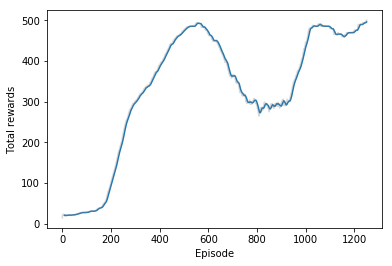

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

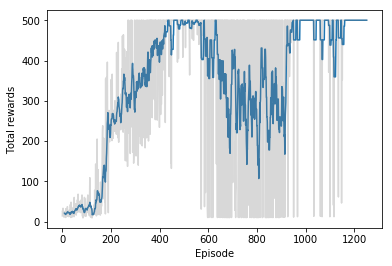

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

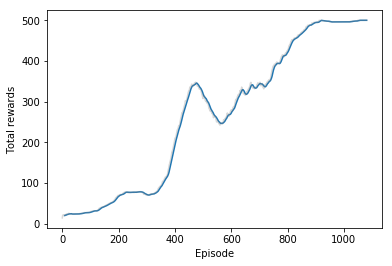

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

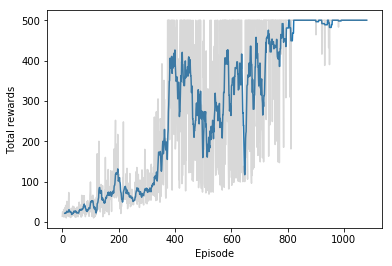

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [25]:
# eps, arr = np.array(dloss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [26]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
